# Cross Validation

## TimeGapSplit

We allow for a timeseries split that contains a gap.

You won't always need it, but sometimes you consider these two situations;

- If you have multiple samples per timestamp: you want to make sure that a timestamp doesn’t appear at the same time in training and validation folds.
- If your target is looking $x$ days ahead in the future. In this case you cannot construct the target of the last x days of your available data. It means that when you put your model in production, the first day that you are going to score is always x days after your last training sample, therefore you should select the best model according to that setup. In other words, if you keep that gap in the validation, your metric might be overestimated because those first x days might be easier to predict since they are closer to the training set. If you want to be strict in terms of robustness you might want to replicate in the CV exactly this real-world behaviour, and thus you want to introduce a gap of x days between your training and validation folds.

TimeGapSplit provides 4 parameters to really reproduce your production implementation in your cross-validation schema. We will demonstrate this in a code example below. 

#### Examples

Let's make some random data to start with, and next define a plotting function.

In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta

from sklego.model_selection import TimeGapSplit

In [3]:
df = (pd.DataFrame(np.random.randint(0, 30, size=(30, 4)), columns=list('ABCy'))
      .assign(date=pd.date_range(start='1/1/2018', end='1/30/2018')[::-1]))
print(df.shape)

# For performance testing
if False:
    df = pd.concat([df]*50000, axis=0)
    df = df.reset_index(drop=True)
    df.index = df.index + 22
    print(df.shape)

(30, 5)


In [4]:
df.head()

,A,B,C,y,date
0,5,23,13,9,2018-01-30
1,4,13,24,4,2018-01-29
2,18,20,27,5,2018-01-28
3,2,4,8,19,2018-01-27
4,13,26,20,29,2018-01-26


In [5]:
def plot_cv(cv, X):
    """
    Plot all the folds on time axis
    :param pandas.DataFrame X:
    """
    X_index_df = cv._join_date_and_x(X)

    plt.figure(figsize=(16, 4))
    for i, split in enumerate(cv.split(X)):
        x_idx, y_idx = split
        x_dates = X_index_df.iloc[x_idx]['__date__'].unique()
        y_dates = X_index_df.iloc[y_idx]['__date__'].unique()
        plt.plot(x_dates, i*np.ones(x_dates.shape), c="steelblue")
        plt.plot(y_dates, i*np.ones(y_dates.shape), c="orange")

    plt.legend(('training', 'validation'), loc='upper left')
    plt.ylabel('Fold id')
    plt.axvline(x=X_index_df['__date__'].min(), color='gray', label='x')
    plt.axvline(x=X_index_df['__date__'].max(), color='gray', label='d')

**Example 1**

In [6]:
cv = TimeGapSplit(date_serie=df['date'],
                  train_duration=timedelta(days=10),
                  valid_duration=timedelta(days=2),
                  gap_duration=timedelta(days=1))

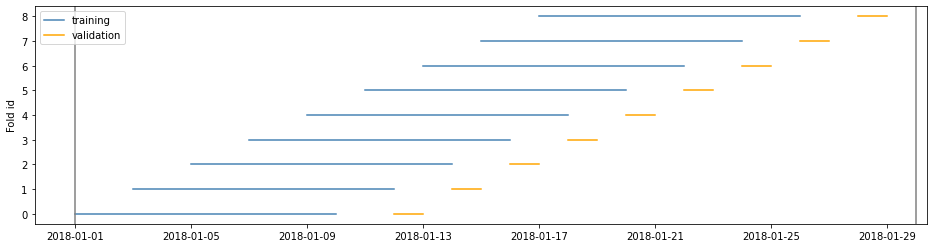

In [7]:
plot_cv(cv, df)

**Example 2**

In [8]:
cv = TimeGapSplit(date_serie=df['date'],
                  train_duration=timedelta(days=10),
                  valid_duration=timedelta(days=5),
                  gap_duration=timedelta(days=1))

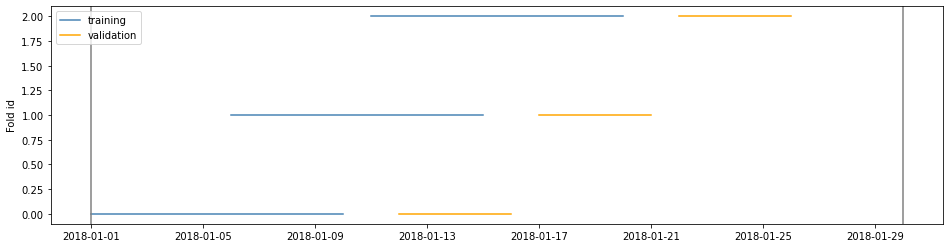

In [9]:
plot_cv(cv, df)

**Example 3**

window='expanding' is the closest to the sklearn implementation

In [10]:
cv = TimeGapSplit(date_serie=df['date'],
                  train_duration=timedelta(days=10),
                  valid_duration=timedelta(days=2),
                  gap_duration=timedelta(days=1),
                  window='expanding')

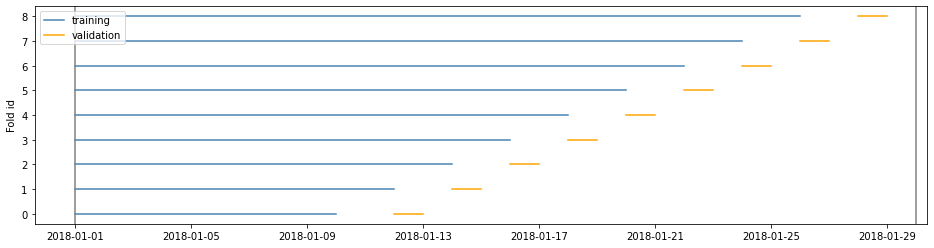

In [11]:
plot_cv(cv, df)

**Example 4**

If train_duration is not passed the training duration is the maximum without overlapping validation folds

In [12]:
cv = TimeGapSplit(date_serie=df['date'],
                  train_duration=None,
                  valid_duration=timedelta(days=3),
                  gap_duration=timedelta(days=2),
                  n_splits=3)

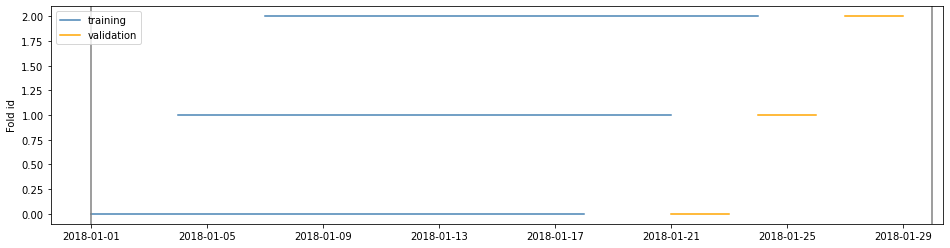

In [13]:
plot_cv(cv, df)

**Example 5**

If train and valid duration would lead to unwanted amounts of splits n_splits can set a maximal amount of splits

In [14]:
cv = TimeGapSplit(date_serie=df['date'],
                  train_duration=timedelta(days=10),
                  valid_duration=timedelta(days=2),
                  gap_duration=timedelta(days=1),
                  n_splits=4)

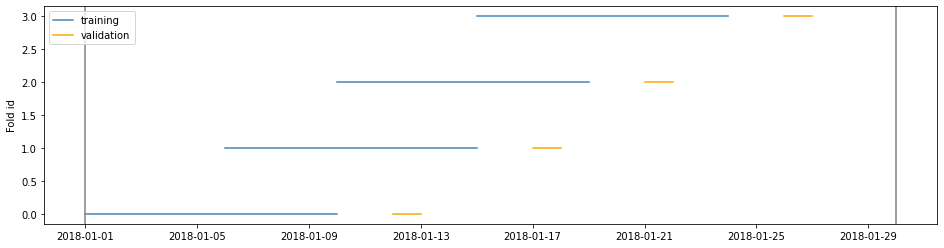

In [15]:
plot_cv(cv, df)

In [16]:
cv.summary(df)

,Start date,End date,Period,Unique days,nbr samples
"(0, train)",2018-01-01,2018-01-10,9 days,10,10
"(0, valid)",2018-01-12,2018-01-13,1 days,2,2
"(1, train)",2018-01-06,2018-01-15,9 days,10,10
"(1, valid)",2018-01-17,2018-01-18,1 days,2,2
"(2, train)",2018-01-10,2018-01-19,9 days,10,10
"(2, valid)",2018-01-21,2018-01-22,1 days,2,2
"(3, train)",2018-01-15,2018-01-24,9 days,10,10
"(3, valid)",2018-01-26,2018-01-27,1 days,2,2


## GroupTimeSeriesSplit

In a time series problem it is possible that not every time unit (e.g. years) has the same amount of rows/observations. This makes a normal kfold split impractical as you cannot specify a certain timeframe per fold (e.g. 5 years), because this can cause the folds' sizes to be very different. With `GroupTimeSeriesSplit` you can specify the amount of folds you want (e.g. `n_splits=3`) and `GroupTimeSeriesSplit` will calculate itself folds in such a way that the amount of observations per fold are as similar as possible. <br>

The folds are created with a smartly modified brute forced method. This still means that for higher `n_splits` values in combination with many different unique time periods (e.g. 100 different years, thus 100 groups) the generation of the optimal split points can take minutes to hours. `UserWarnings` are raised when `GroupTimeSeriesSplit` expects to be running over a minute. Of course, this actual runtime depends on your machine's specifications.

### Examples

In [6]:
import numpy as np
import pandas as pd

from sklego.model_selection import GroupTimeSeriesSplit

First let's create an example data set.

In [7]:
X = np.random.randint(low=1, high=1000, size=17)
y = np.random.randint(low=1, high=1000, size=17)
groups = np.array([2000,2000,2000,2001,2002,2002,2003,2004,2004,2004,2004,2004,2005,2005,2006,2006,2007])

df = pd.DataFrame(np.vstack((X,y)).T, index=groups, columns=['X','y'])
df

,X,y
2000,726,848
2000,171,259
2000,954,954
2001,477,719
2002,225,488
2002,115,650
2003,842,761
2004,940,298
2004,868,817
2004,330,954


Create a `GroupTimeSeriesSplit` cross-validator with kfold/n_splits = 3

In [8]:
cv = GroupTimeSeriesSplit(n_splits=3)

def print_folds(cv, X, y, groups):
    for kfold, (train, test) in enumerate(cv.split(X, y, groups)):
        print(f"Fold {kfold+1}:")
        print(f"Train = {df.iloc[train].index.tolist()}")
        print(f"Test = {df.iloc[test].index.tolist()}\n\n")
    
print_folds(cv, X, y, groups)

Fold 1:
Train = [2000, 2000, 2000, 2001]
Test = [2002, 2002, 2003]


Fold 2:
Train = [2002, 2002, 2003]
Test = [2004, 2004, 2004, 2004, 2004]


Fold 3:
Train = [2004, 2004, 2004, 2004, 2004]
Test = [2005, 2005, 2006, 2006, 2007]




![img1](_static/GroupTimeSeriesSplit_example.drawio.png)

As you can see above `GroupTimeSeriesSplit` keeps the order of the time chronological and makes sure that the same time value won't appear in both the train and test set of the same fold.

`GroupTimeSeriesSplit` also has the `.summary()` method, in which is shown which time values are grouped together. Because of the chronological order the train and test folds need to be, the amount of `groups` is always `n_splits` + 1. (see the four folds in the image above with `Kfold=3`)

In [9]:
cv.summary()

,index,observations,group,obs_per_group,ideal_group_size,diff_from_ideal_group_size
0,2000,3,0,4,4,0
1,2001,1,0,4,4,0
2,2002,2,1,3,4,-1
3,2003,1,1,3,4,-1
4,2004,5,2,5,4,1
5,2005,2,3,5,4,1
6,2006,2,3,5,4,1
7,2007,1,3,5,4,1


To use `GroupTimeSeriesSplit` with sklearn's [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html):

In [10]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

# reshape X for the Lasso model
X = X.reshape(-1,1)

# initiate the cross validator
cv = GroupTimeSeriesSplit(n_splits=3)

# generate the train-test splits
cv_splits = cv.split(X=X, y=y, groups=groups)

# initiate the Lasso model
Lasso(random_state=0, tol=0.1, alpha=0.8).fit(X, y, groups)
pipe = Pipeline([("reg", Lasso(random_state=0, tol=0.1))])


# initiate GridSearchCv with cv_splits as parameter
alphas = [0.1, 0.5, 0.8]
grid = GridSearchCV(pipe, {"reg__alpha": alphas}, cv=cv_splits)
grid.fit(X, y)
grid.best_estimator_.get_params()["reg__alpha"]

0.8